In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import os
import keras
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings("ignore")

# The following data are obtained from https://github.com/hwchase17/sportvu

data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]


data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]


Using TensorFlow backend.


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

data = data[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG",'season']]
data = pd.get_dummies(data,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
data = data.dropna()
data = data[data['season'] == '2013']

data = data.drop(['season'], axis = 1)

train_X = data.drop(['SHOT_MADE_FLAG'],axis = 1)
train_y = to_categorical(data['SHOT_MADE_FLAG'])


early_stopping_monitor = EarlyStopping(patience=3,min_delta = 0.1,monitor='val_acc')
model_check_point = ModelCheckpoint("shot_make_model/model_sm.{epoch:02d}-{val_acc:.2f}.hdf5",monitor = 'val_acc',mode = 'max',save_best_only = True)

model= Sequential()
n_cols = train_X.shape[1]
model.add(Dense(250, activation='relu', input_shape=(n_cols,)))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=30,validation_split=0.2, callbacks=[model_check_point,early_stopping_monitor])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 150496 samples, validate on 37624 samples
Epoch 1/30
150496/150496 [==============================] - 89s 591us/step - loss: 0.6236 - acc: 0.6510 - val_loss: 0.6174 - val_acc: 0.6565
Epoch 2/30
150496/150496 [==============================] - 102s 680us/step - loss: 0.6093 - acc: 0.6609 - val_loss: 0.6156 - val_acc: 0.6586
Epoch 3/30
150496/150496 [==============================] - 88s 584us/step - loss: 0.6026 - acc: 0.6650 - val_loss: 0.6203 - val_acc: 0.6571
Epoch 4/30
150496/150496 [==============================] - 90s 597us/step - loss: 0.5955 - acc: 0.6701 - val_loss: 0.6199 - val_acc: 0.6561


Test set accuracy:  0.657110970884419
The model's brier score is:  0.21556308994141607
The climatology's brier score is:  0.24782561508100734


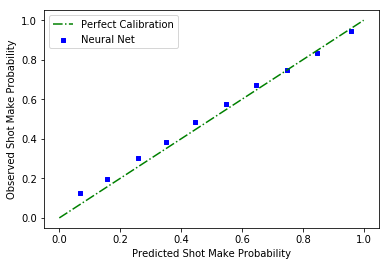

In [3]:
# out-of-sample accuracy (2014-15 season)
# load the best model 

#m = [f for f in sorted(os.listdir('shot_make_model')) if 'hdf5' in f][-1]
#model = keras.models.load_model('shot_make_model/'+m)

# reload the data for both seasons in order to create the correct dummy variables 
data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]
data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]
test = data
test = test[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG","season"]]
test = pd.get_dummies(test,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
test = test[test['season']== '2014']
test = test.drop(['season'],axis = 1)
test = test.dropna()

test_X = test.drop(['SHOT_MADE_FLAG'],axis =1)
test_y = to_categorical(test['SHOT_MADE_FLAG'])
test_y_predictions = model.predict(test_X)

print("Test set accuracy: ",np.sum(np.round(test_y_predictions[:,1]) == test['SHOT_MADE_FLAG'])/test.shape[0])

# brier score

print("The model's brier score is: ",  brier_score_loss(test['SHOT_MADE_FLAG'],test_y_predictions[:,1]))
print("The climatology's brier score is: ", brier_score_loss(test['SHOT_MADE_FLAG'],(sum(test['SHOT_MADE_FLAG'])/len(test))*np.ones(test.shape[0])))

observed, predicted = calibration_curve(test['SHOT_MADE_FLAG'], test_y_predictions[:,1], n_bins = 10)

fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.linspace(0,1,10000)
y = x
ax1.plot(x,y,'-.g',label="Perfect Calibration")

ax1.scatter(predicted,observed,s=20, c='b', marker="s", label = "Neural Net")


plt.xlabel("Predicted Shot Make Probability")
plt.ylabel("Observed Shot Make Probability")
plt.legend(loc='upper left');
plt.show()

In [5]:
data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]
data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]
test = data
test = test[test['season']== '2014']
test = test.dropna()
test['prob'] = test_y_predictions[:,1]

shots_pl = test.groupby('PLAYER_ID')

players = []

for p in test['PLAYER_ID'].unique():
    if len(shots_pl.get_group(p)) > 1000:
        players.append(p)

for p in players: 
    player_df = shots_pl.get_group(p)
    player_df_games = player_df.groupby("GAME_ID")
    tt_true = 0
    tf_true = 0
    # find the games that we have full data for the player
    games_p = []
    for g in player_df['GAME_ID'].unique():
        tmp = player_df_games.get_group(g)
        if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER):
            games_p.append(g)
     
    for g in games_p:
        tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
        for i in range(len(list(tmp))-1):
            if list(tmp)[i] == 1:
                if list(tmp)[i+1] == 1:
                    tt_true+=1
                else:
                    tf_true+=1
    tt_prob_sim = []
    for _ in range(1000):
        tt_sim=0
        tf_sim=0
        for g in games_p:
            # sample binomial for each shot
            probs = list(player_df_games.get_group(g)['prob'])
            tmp = [np.random.binomial(1,probs[i]) for i in range(len(probs))]
            for i in range(len(list(tmp))-1):
                if list(tmp)[i] == 1:
                    if list(tmp)[i+1] == 1:
                        tt_sim += 1
                    else:
                        tf_sim+=1
        tt_prob_sim.append(tt_sim/(tt_sim+tf_sim))
    print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],tt_true/(tt_true+tf_true),np.mean(tt_prob_sim),0.001*len([tt_prob_sim[i] for i in range(len(tt_prob_sim)) if tt_prob_sim[i]>(tt_true/(tt_true+tf_true))]))
        

LaMarcus Aldridge 0.43656716417910446 0.40407244073696674 0.158
Rudy Gay 0.43564356435643564 0.3905014718316884 0.19
Pau Gasol 0.5416666666666666 0.4450575496269276 0.011
Chris Paul 0.4873417721518987 0.4153074308560483 0.039
Anthony Davis 0.6150793650793651 0.4947812322529841 0.0
Damian Lillard 0.41919191919191917 0.3953719242042501 0.243
Victor Oladipo 0.4358974358974359 0.4136955582551227 0.28400000000000003
LeBron James 0.4555160142348754 0.4944658750167908 0.913
Dwyane Wade 0.47368421052631576 0.48290254908071406 0.592
Monta Ellis 0.41935483870967744 0.43145740299483465 0.626
Russell Westbrook 0.48148148148148145 0.4257793423797822 0.026000000000000002
Andrew Wiggins 0.49473684210526314 0.4097479673182437 0.042
Blake Griffin 0.425 0.427857104278166 0.537
James Harden 0.4359861591695502 0.43268129285299656 0.465
Tyreke Evans 0.42245989304812837 0.41932910790154365 0.485
Stephen Curry 0.4774774774774775 0.4796196887375731 0.537
John Wall 0.42857142857142855 0.41207175770007426 0.282

# Example from Figure 1

In [6]:
sequence = [1,1,1,0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,0,0]

tt_true = 0
tf_true = 0
for i in range(len(list(sequence))-1):
    if list(sequence)[i] == 1:
        if list(sequence)[i+1] == 1:
            tt_true+=1
        else:
            tf_true+=1
tt_prob_sim = []
for _ in range(1000):
    tt_sim=0
    tf_sim=0
    tmp = np.random.permutation(sequence)
    for i in range(len(list(tmp))-1):
        if list(tmp)[i] == 1:
            if list(tmp)[i+1] == 1:
                tt_sim += 1
            else:
                tf_sim+=1
    tt_prob_sim.append(tt_sim/(tt_sim+tf_sim))
print(tt_true/(tt_true+tf_true),np.mean(tt_prob_sim),0.001*len([tt_prob_sim[i] for i in range(len(tt_prob_sim)) if tt_prob_sim[i]>(tt_true/(tt_true+tf_true))]))
        

0.6 0.47336666666666666 0.074


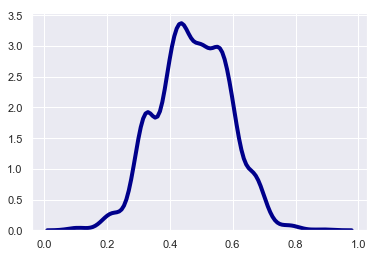

In [7]:
import seaborn as sns, numpy as np

sns.set(); np.random.seed(0)
ax = sns.distplot(tt_prob_sim,hist=False,kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})